# Final results from our neural network
Code is taken from <strong><code>Jackson/Model-Test.py</code></strong>

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import numpy as np

# =============================
# 0. Get scaler from 2001-2022
# =============================
def get_scaler():
    df = pd.read_csv("../data/train_val_2001_2021.csv")
    scaler = StandardScaler()
    scaler.fit(df[numeric_cols])
    return scaler

# =============================
# 1. Load test data (2022)
# =============================
test_df = pd.read_csv("../data/final_test_2022.csv")  # Your 2022 data
TARGET_COL = "RectifHyd_MWh"

# Ensure numeric target
test_df[TARGET_COL] = pd.to_numeric(test_df[TARGET_COL], errors='coerce')
test_df = test_df.dropna(subset=[TARGET_COL])

# Ensure numeric features
numeric_cols = [c for c in test_df.columns if c not in ["Division_ID", "Primary Purpose", "nerc_region", "mode", TARGET_COL, 'year']]
for col in numeric_cols:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# =============================
# 2. Load preprocessing objects
# =============================
with open("../artifacts/label_encoders.pkl", "rb") as f:
    label_encoders = pickle.load(f)
with open("../artifacts/scaler.pkl", "rb") as f:
    scaler = get_scaler()

categorical_cols = ["Division_ID", "Primary Purpose", "nerc_region", "mode"]

# Fill missing numeric values with median from test set
for col in numeric_cols:
    test_df[col] = test_df[col].fillna(test_df[col].median())

# Encode categorical features using training label encoders
for col in categorical_cols:
    le = label_encoders[col]
    test_df[col] = le.transform(test_df[col].astype(str))

# Scale numeric features
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

# Convert to tensors
X_numeric_test = torch.tensor(test_df[numeric_cols].values, dtype=torch.float32)
X_categorical_test = torch.tensor(test_df[categorical_cols].values, dtype=torch.long)
y_test = torch.tensor(test_df[TARGET_COL].values, dtype=torch.float32).unsqueeze(1)

# =============================
# 3. Dataset & DataLoader
# =============================
class DamEnergyDataset(Dataset):
    def __init__(self, X_num, X_cat, y):
        self.X_num = X_num
        self.X_cat = X_cat
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

test_dataset = DamEnergyDataset(X_numeric_test, X_categorical_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

# =============================
# 4. Load trained model
# =============================
class DamNN(nn.Module):
    def __init__(self, n_numeric, categorical_cardinalities, emb_dim=16, hidden_dim=128):
        super(DamNN, self).__init__()
        self.embeddings = nn.ModuleList(
            [nn.Embedding(cardinality, emb_dim) for cardinality in categorical_cardinalities]
        )
        n_emb = emb_dim * len(categorical_cardinalities)
        self.fc1 = nn.Linear(n_numeric + n_emb, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x_num, x_cat):
        embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat([x_num] + embs, dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

categorical_cardinalities = [len(label_encoders[col].classes_) for col in categorical_cols]
model = DamNN(len(numeric_cols), categorical_cardinalities)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("../artifacts/best_dam_model.pt", map_location=device))
model.to(device)
model.eval()

# =============================
# 5. Evaluate
# =============================
preds, targets = [], []

with torch.no_grad():
    for X_num_batch, X_cat_batch, y_batch in test_loader:
        X_num_batch, X_cat_batch = X_num_batch.to(device), X_cat_batch.to(device)
        outputs = model(X_num_batch, X_cat_batch)
        preds.append(outputs.cpu())
        targets.append(y_batch)

preds = torch.cat(preds).numpy()
targets = torch.cat(targets).numpy()

rmse = np.sqrt(mean_squared_error(targets, preds))
mae = mean_absolute_error(targets, preds)
r2 = r2_score(targets, preds)

print(f"2022 Test Results | RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

/Users/sreelakshmijs/miniforge3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


2022 Test Results | RMSE: 45124.52, MAE: 10181.40, R²: 0.694


# Results from LightGBM
Code is taken from <strong><code>Sreelakshmi/lightGBM_test.py</code></strong>

/Users/sreelakshmijs/miniforge3/envs/erdos_ds_environment/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Test rows: 14016
Loaded LightGBM model from ../artifacts/best_dam_lgbm.model
Best iteration: -1

2022 Test Results (LightGBM)
RMSE: 21589.29
MAE:  5347.67
R²:   0.930


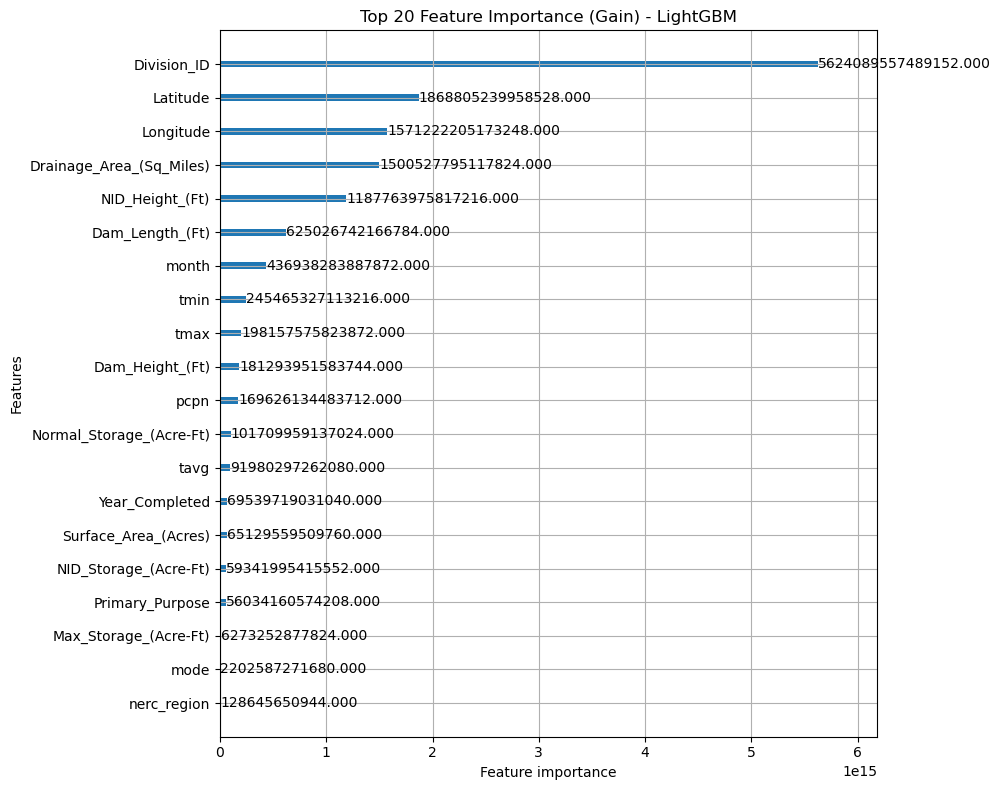

In [4]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import os

# =============================
# 1. Load test data (2022)
# =============================
test_df = pd.read_csv("../data/final_test_2022.csv")  # Your 2022 data
TARGET_COL = "RectifHyd_MWh"

# Ensure numeric target
test_df[TARGET_COL] = pd.to_numeric(test_df[TARGET_COL], errors='coerce')
test_df = test_df.dropna(subset=[TARGET_COL])

# =============================
# 2. Define columns (same as training)
# =============================
categorical_cols = ["Division_ID", "Primary Purpose", "nerc_region", "mode"]
numeric_cols = [c for c in test_df.columns if c not in categorical_cols + [TARGET_COL, 'year']]

# Ensure numeric features
for col in numeric_cols:
    test_df[col] = pd.to_numeric(test_df[col], errors='coerce')

# =============================
# 3. Load preprocessing objects
# =============================
with open("../artifacts/label_encoders.pkl", "rb") as f:  # Updated path
    label_encoders = pickle.load(f)
with open("../artifacts/scaler.pkl", "rb") as f:
    scaler = get_scaler()
# Fill missing numeric values with median from test set
for col in numeric_cols:
    test_df[col] = test_df[col].fillna(test_df[col].median())

# Encode categorical features using training label encoders
for col in categorical_cols:
    le = label_encoders[col]
    # Handle unseen categories gracefully
    test_df[col] = test_df[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )

# Scale numeric features using training scaler
test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

# =============================
# 4. Prepare features and target
# =============================
X_test = test_df[numeric_cols + categorical_cols]
y_test = test_df[TARGET_COL].values

print(f"Test rows: {len(test_df)}")

# =============================
# 5. Load trained LightGBM model
# =============================
model_path = "../artifacts/best_dam_lgbm.model"
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model not found: {model_path}")

gbm = lgb.Booster(model_file=model_path)
print(f"Loaded LightGBM model from {model_path}")
print(f"Best iteration: {gbm.best_iteration}")

# =============================
# 6. Predict & Evaluate
# =============================
# Predict using best iteration
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Compute metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n2022 Test Results (LightGBM)")
print(f"RMSE: {rmse:.2f}")
print(f"MAE:  {mae:.2f}")
print(f"R²:   {r2:.3f}")

# =============================
# 7. Optional: Feature importance
# =============================
import matplotlib.pyplot as plt

lgb.plot_importance(gbm, max_num_features=20, importance_type='gain', figsize=(10, 8))
plt.title("Top 20 Feature Importance (Gain) - LightGBM")
plt.tight_layout()
plt.savefig("../results/final/lightgbm_feature_importance.png")
plt.show()